# Artificial Intelligence (AI) & Machine Learning (ML): Project 3

###### G3: ADEN Abdillahi, AUGER Benjamin, LERNER Shaun, MEES Thomas, SALINAS David

## Introduction

The pharmaceutical company *HumanForYou* wishes to determine which factors are most contributing to their 15% turnover rate, then provide suggestions for which areas deserve the most focus of effort to reduce employee churn.

## Import & Initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

import imblearn
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

target_col = "Attrition"
random_state = 42 # np.random.random()

folder_path = "data"
time_folder_path = "in_out_time"
in_time_file_name = "in_time.csv"
out_time_file_name = "out_time.csv"
employee_file_name = "employee_survey_data.csv"
general_file_name = "general_data.csv"
manager_file_name = "manager_survey_data.csv"

employee_data = pd.read_csv(os.path.join(folder_path, employee_file_name))
general_data = pd.read_csv(os.path.join(folder_path, general_file_name))
manager_data = pd.read_csv(os.path.join(folder_path, manager_file_name))
in_time_data = pd.read_csv(os.path.join(folder_path, time_folder_path, in_time_file_name))
out_time_data = pd.read_csv(os.path.join(folder_path, time_folder_path, out_time_file_name))


This block initializes the analysis environment by importing essential libraries for:
* **Data Manipulation:** `pandas`, `numpy`
* **Visualization:** `matplotlib`
* **Machine Learning:** `sklearn` - Random Forest, metrics, preprocessing, `imblearn` SMOTE (Synthetic Minority Over-sampling Technique) for balancing

It also configures global parameters, such as the `random_state` for reproducibility and the `target_col` ("Attrition"). Finally, it loads the five distinct CSV datasets provided by the HR department (General Data, Employee Survey, Manager Survey, and In/Out Time logs) into Pandas DataFrames.

### In/Out Time Handling

In [2]:
# merge in_time and out_time data on the first column (actually EmployeeID, so rename)
in_time_data.rename(columns={in_time_data.columns[0]: "EmployeeID"}, inplace=True)
out_time_data.rename(columns={out_time_data.columns[0]: "EmployeeID"}, inplace=True)

# confirm days consistency
in_time_days = set(in_time_data.columns[1:])
out_time_days = set(out_time_data.columns[1:])
missing_in_out = in_time_days.difference(out_time_days)
if len(missing_in_out) > 0:
    print(f"Days missing in either in_time or out_time data: {missing_in_out}")

# go through each column to check empty cells present only in one of the datasets
for day in in_time_days.intersection(out_time_days):
    in_time_empty = set(in_time_data.index[in_time_data[day].isnull()])
    out_time_empty = set(out_time_data.index[out_time_data[day].isnull()])
    missing_in_out_rows = in_time_empty.symmetric_difference(out_time_empty)
    if missing_in_out_rows:
        print(f"Day {day} has missing entries in either in_time or out_time data at rows: {missing_in_out_rows}")

# convert all columns except the first one to datetime
for col in in_time_data.columns[1:]:
    in_time_data[col] = pd.to_datetime(in_time_data[col], format="%Y-%m-%d %H:%M:%S", errors="coerce")
for col in out_time_data.columns[1:]:
    out_time_data[col] = pd.to_datetime(out_time_data[col], format="%Y-%m-%d %H:%M:%S", errors="coerce")

def remove_col_depending_on_distinct_values(df, start_threshold=0, end_threshold=0):
    cols_to_remove = []
    for col in df.columns:
        if start_threshold <= df[col].nunique() <= end_threshold:
            cols_to_remove.append(col)
    df.drop(columns=cols_to_remove, inplace=True)
    return df

# combine based on EmployeeID
time_data = pd.merge(in_time_data, out_time_data, on="EmployeeID", suffixes=("_in", "_out"))

# create a new column for duration time in hours
hours_columns = {}
day_of_week_columns = {}
for day in in_time_days.intersection(out_time_days):
    hours_columns[f"{day}_hours"] = (time_data[f"{day}_out"] - time_data[f"{day}_in"]).dt.total_seconds() / 3600.0
    day_of_week_columns[f"{day}_day_of_week"] = time_data[f"{day}_in"].dt.dayofweek

# duration_hours
time_data = pd.concat([time_data, pd.DataFrame(hours_columns, index=time_data.index)], axis=1)
time_data = pd.concat([time_data, pd.DataFrame(day_of_week_columns, index=time_data.index)], axis=1)
time_data["duration_hours"] = time_data[list(hours_columns.keys())].sum(axis=1)

# aggregate by day of week
day_of_week_counts = {}
day_of_week_avg_hours = {}
for i in range(7): # 0=Monday through 6=Sunday
    count_cols = [col for col in time_data.columns if col.endswith("_day_of_week")]
    day_of_week_counts[f"worked_on_day_{i}"] = sum(
        (time_data[col] == i).astype(int) for col in count_cols
    )
    
    # avg hrs per day of week
    total_hours = 0
    for day in in_time_days.intersection(out_time_days):
        day_col = f"{day}_day_of_week"
        hours_col = f"{day}_hours"
        if day_col in time_data.columns and hours_col in time_data.columns:
            # only sum hours where the day of week matches
            mask = time_data[day_col] == i
            total_hours += time_data[hours_col].where(mask, 0)
    day_of_week_avg_hours[f"avg_hours_day_{i}"] = total_hours / day_of_week_counts[f"worked_on_day_{i}"].replace(0, 1)

time_data = pd.concat([time_data, pd.DataFrame(day_of_week_counts, index=time_data.index)], axis=1)
time_data = pd.concat([time_data, pd.DataFrame(day_of_week_avg_hours, index=time_data.index)], axis=1)

# remove columns with 0 distinct values
remove_col_depending_on_distinct_values(time_data)

# keep only columns: EmployeeID, duration_hours, worked_on_day_*, avg_hours_day_*
cols_to_keep = ["EmployeeID", "duration_hours"] + [col for col in time_data.columns if col.startswith("worked_on_day_") or col.startswith("avg_hours_day_")]
time_data = time_data[cols_to_keep]
time_data = pd.concat([time_data, pd.DataFrame(hours_columns, index=time_data.index)], axis=1)



This block focuses on transforming raw arrival and departure logs into useful behavioral metrics:

* **Data Cleaning & Validation:** Renames the primary key to `EmployeeID`, checks for inconsistencies between the in_time and out_time files (missing days or mismatched rows), and converts all timestamp strings into datetime objects.
* **Daily Calculations:** Merges the datasets and calculates the daily duration of work (Departure Time - Arrival Time) and identifies the specific day of the week for each date.
* **Aggregation:** Generates summary statistics per employee to capture work habits:
    * `duration_hours`: Total hours worked over the recorded period.
    * `worked_on_day_X`: Frequency of working on specific weekdays (0=Mon to 6=Sun).
    * `avg_hours_day_X`: Average shift length for each specific weekday.
* **Final Filtering:** Discards the raw daily timestamp columns, retaining only the `EmployeeID` and the newly calculated aggregated features for the final dataset.

## Merge

In [3]:
print("\n" + "="*70)
print("Data Merging")
print("="*70)

# Merge employee and manager data first
employee_manager_data = pd.merge(employee_data, manager_data, on="EmployeeID", suffixes=("_emp", "_mgr"))
# Merge all datasets into a final dataset on EmployeeID
raw_dataset = pd.merge(general_data, employee_manager_data, on="EmployeeID")
raw_dataset = pd.merge(raw_dataset, time_data, on="EmployeeID")

# Drop unethical columns BEFORE split
raw_dataset.drop(columns=["MaritalStatus", "Gender", "Age"], inplace=True)

print(f"Total dataset size: {len(raw_dataset)} samples")
print(f"Features: {len(raw_dataset.columns)} columns")


Data Merging
Total dataset size: 4410 samples
Features: 302 columns



This block merges all separate data sources into a single master dataset for analysis and applies ethical constraints:

* **Integration:** Joins `general_data`, `employee_survey_data`, `manager_survey_data`, and the processed `time_data` into one unified DataFrame (`raw_dataset`) using `EmployeeID` as the unique key.
* **Ethical Feature Selection:** Proactively removes sensitive demographic attributes—`MaritalStatus`, `Gender`, and `Age`—before training. This ensures the predictive model focuses on performance and work environment factors rather than personal characteristics, mitigating the risk of bias or discrimination.
* **Verification:** Prints the final row and column counts to confirm the data integration process.

### Ethics
We've already needed to consider ethics here for which columns should remain before proceeding with the training/testing split, so we've dedicated a section for ethics below.

## Feature Engineering & Split

In [4]:
print("\n" + "="*70)
print("Feature Engineering & Split")
print("="*70)

def create_advanced_features(df):
    df = df.copy()
    
    if 'YearsSinceLastPromotion' in df.columns:
        df['YearsWithoutPromotion'] = df['YearsSinceLastPromotion']
    
    if 'YearsAtCompany' in df.columns and 'YearsSinceLastPromotion' in df.columns:
        df['PromotionRate'] = df['YearsAtCompany'] / (df['YearsSinceLastPromotion'] + 1)
    
    if 'YearsInCurrentRole' in df.columns:
        df['CareerStagnation'] = (df['YearsInCurrentRole'] > 5).astype(int)
    
    if 'MonthlyIncome' in df.columns and 'YearsAtCompany' in df.columns:
        df['IncomePerYear'] = df['MonthlyIncome'] * 12 / (df['YearsAtCompany'] + 1)
    
    if 'PercentSalaryHike' in df.columns:
        df['IncomeGrowthRate'] = df['PercentSalaryHike'] / 100
    
    if 'duration_hours' in df.columns:
        df['AvgDailyHours'] = df['duration_hours'] / 260
        df['Overwork'] = (df['AvgDailyHours'] > 9).astype(int)
        df['Overtime'] = (df['AvgDailyHours'] > 8).astype(int)
    
    weekend_cols = ['worked_on_day_5', 'worked_on_day_6'] # Saturday and Sunday
    if all(col in df.columns for col in weekend_cols):
        weekend_work = df['worked_on_day_5'] + df['worked_on_day_6']
        df['WeekendWorker'] = (weekend_work > 10).astype(int) # worked more than 10 weekends
    
    satisfaction_cols = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance']
    if all(col in df.columns for col in satisfaction_cols):
        df['OverallSatisfaction'] = (
            df['JobSatisfaction'] + 
            df['EnvironmentSatisfaction'] + 
            df['WorkLifeBalance']
        ) / 3
        df['LowSatisfaction'] = (df['OverallSatisfaction'] < 2).astype(int)

    # advanced indicator
    if all(col in df.columns for col in ['YearsWithoutPromotion', 'JobSatisfaction', 'WorkLifeBalance']):
        df['HighRiskProfile'] = (
            (df['YearsWithoutPromotion'] > 3) & 
            (df['JobSatisfaction'] < 3) &
            (df['WorkLifeBalance'] < 3)
        ).astype(int)
    
    if 'TotalWorkingYears' in df.columns and 'MonthlyIncome' in df.columns:
        df['ExperienceIncomeRatio'] = df['TotalWorkingYears'] / (df['MonthlyIncome'] / 1000 + 1)
    
    if 'NumCompaniesWorked' in df.columns and 'TotalWorkingYears' in df.columns:
        df['JobChangeFrequency'] = df['NumCompaniesWorked'] / (df['TotalWorkingYears'] + 1)
    
    return df

# Apply feature engineering BEFORE split to avoid leakage
raw_dataset = create_advanced_features(raw_dataset)
print(f"Features after engineering: {len(raw_dataset.columns)} columns")
raw_dataset.drop(columns=["EmployeeID"], inplace=True)
print("Advanced features created successfully")

# Split BEFORE any preprocessing to avoid data leakage
train_set, test_set = train_test_split(raw_dataset, test_size=0.2, random_state=random_state, stratify=raw_dataset['Attrition'])

print(f"Train set: {len(train_set)} samples")
print(f"Test set: {len(test_set)} samples")
print(f"Train class distribution: {train_set['Attrition'].value_counts().to_dict()}")
print(f"Test class distribution: {test_set['Attrition'].value_counts().to_dict()}")


Feature Engineering & Split
Features after engineering: 315 columns
Advanced features created successfully
Train set: 3528 samples
Test set: 882 samples
Train class distribution: {'No': 2959, 'Yes': 569}
Test class distribution: {'No': 740, 'Yes': 142}



This block enhances the dataset's predictive power by deriving new business-relevant metrics and then partitioning the data for validation.

* **Feature Engineering:** The `create_advanced_features` function generates complex indicators based on HR logic, including:
    * **Career Progression:** Metrics like `PromotionRate` and `CareerStagnation` to detect lack of growth.
    * **Work-Life Balance:** Variables derived from time logs, such as `AvgDailyHours`, `Overtime` (working >8h), and `WeekendWorker`.
    * **Composite Scores:** `OverallSatisfaction` combines multiple survey results, and `HighRiskProfile` flags employees showing multiple warning signs simultaneously.
* **Data Splitting:**
    * Removes the non-predictive `EmployeeID` column.
    * Performs a **Stratified Train/Test Split** (80% training, 20% testing). Stratification is critical here to ensure the minority class ("Yes" for Attrition) is represented proportionally in both sets.

## Data Visualization

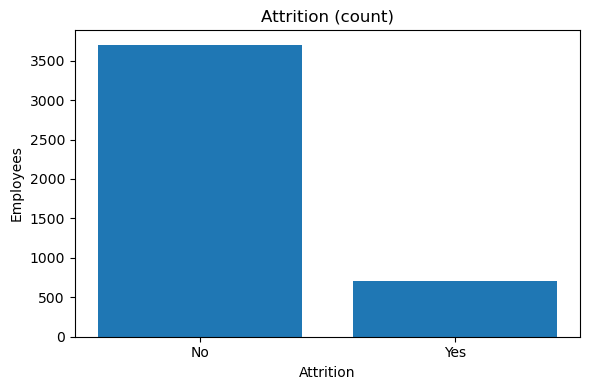

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = raw_dataset.copy()
counts = df["Attrition"].value_counts().reindex(["No", "Yes"])
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Attrition (count)")
plt.xlabel("Attrition")
plt.ylabel("Employees")
plt.tight_layout()
plt.show()

Based on the **attrition graph**, we observe that the target variable (**Attrition**) is **imbalanced**: there are **many more “No”** cases than **“Yes”** cases (employees who left are the minority class).

**Implication:** if we train a model on this as-is, it may learn to predict mostly **“No”** and **overfit** still obtain an apparently good accuracy, while performing poorly at detecting the **“Yes”** class.

**Planned fix (later, during modeling):** we will apply a rebalancing technique such as **SMOTE** to generate additional synthetic samples of the minority class. This will be done **only on the training set** (after the train/test split) to avoid data leakage and keep the test set representative of real-world proportions. 

## Pipeline

In [6]:
def preprocess_data_safe(dataset, fitted_scaler=None, fitted_imputers=None, fit_mode=True, 
                          encode_ordinal_cols=None, remove_from_encoding=[]):
    """
    Preprocess data with proper train/test separation.
    
    Args:
        dataset: DataFrame to preprocess
        fitted_scaler: Pre-fitted StandardScaler (for test set)
        fitted_imputers: Dict of pre-fitted imputation values (for test set)
        fit_mode: If True, fit transformers. If False, use provided transformers
        encode_ordinal_cols: Dict of ordinal encodings
        remove_from_encoding: Columns to exclude from encoding
    
    Returns:
        data: Preprocessed DataFrame
        scaler: Fitted StandardScaler
        imputers: Dict of imputation values
    """
    data = dataset.copy()
    
    # remove useless columns
    constant_cols = [col for col in data.columns if data[col].nunique() <= 1]
    if constant_cols:
        data.drop(columns=constant_cols, inplace=True)
    
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()

    if 'EmployeeID' in numeric_cols:
        numeric_cols.remove('EmployeeID')

    # remove target col from X
    if 'Attrition' in numeric_cols:
        numeric_cols.remove('Attrition')
    
    # imputation
    if fit_mode:
        # fit
        imputers = {}
        if len(numeric_cols) > 0:
            imputers['numeric'] = data[numeric_cols].median()
        if len(categorical_cols) > 0:
            imputers['categorical'] = data[categorical_cols].mode().iloc[0] if len(data[categorical_cols].mode()) > 0 else {}
    else:
        # transform
        imputers = fitted_imputers
    
    if len(numeric_cols) > 0 and 'numeric' in imputers:
        data[numeric_cols] = data[numeric_cols].fillna(imputers['numeric'])
    if len(categorical_cols) > 0 and 'categorical' in imputers:
        data[categorical_cols] = data[categorical_cols].fillna(imputers['categorical'])
    
    # ordinal
    if encode_ordinal_cols:
        for col, categories in encode_ordinal_cols.items():
            if col in data.columns:
                data[col] = pd.Categorical(data[col], categories=categories, ordered=True).codes
                if col in categorical_cols:
                    categorical_cols.remove(col)
                if col not in numeric_cols:
                    numeric_cols.append(col)
    
    # one-hot
    cols_to_encode = [col for col in categorical_cols if col not in remove_from_encoding]
    if len(cols_to_encode) > 0:
        data = pd.get_dummies(data, columns=cols_to_encode, drop_first=True)

    # after encoding categorical, recover numeric
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    if 'Attrition' in numeric_cols:
        numeric_cols.remove('Attrition')
    if 'EmployeeID' in numeric_cols:
        numeric_cols.remove('EmployeeID')
    
    # scale numeric
    if fit_mode:
        # fit
        scaler = StandardScaler()
        if len(numeric_cols) > 0:
            data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    else:
        # transform
        scaler = fitted_scaler
        if len(numeric_cols) > 0 and scaler is not None:
            data[numeric_cols] = scaler.transform(data[numeric_cols])
    
    return data, scaler, imputers


This function (`preprocess_data_safe`) prepares the raw data for machine learning while strictly preventing **data leakage** (ensuring information from the test set does not influence the training process). It operates in two modes: `fit_mode=True` (learning from training data) or `fit_mode=False` (applying learned parameters to test data).

**Key steps include:**
* **Cleaning:** Removes columns with constant values (zero variance).
* **Imputation:** Fills missing values using the *median* for numerical columns and the *mode* for categorical columns (calculated solely on training data).
* **Encoding:** Converts categorical variables into numbers using **Ordinal Encoding** (for ranked data) and **One-Hot Encoding** (for nominal data like Job Role).
* **Scaling:** Standardizes numerical features (Mean=0, Std=1) using `StandardScaler` to ensure all features contribute equally to the model.

## Preprocessing

In [7]:
print("\n" + "="*70)
print("Preprocessing Train and Test Sets Separately")
print("="*70)

ordinal_mappings = {
    "BusinessTravel": ["Non-Travel", "Travel_Rarely", "Travel_Frequently"]
}

mutual_info_columns = ["Department", "EducationField", "JobRole"]

# Attrition to numeric
if train_set[target_col].dtype == "object":
    train_set[target_col] = train_set[target_col].apply(lambda x: 1 if str(x).lower() in ["yes", "1"] else 0)
if test_set[target_col].dtype == "object":
    test_set[target_col] = test_set[target_col].apply(lambda x: 1 if str(x).lower() in ["yes", "1"] else 0)

# preprocess training
train_processed, fitted_scaler, fitted_imputers = preprocess_data_safe(
    train_set,
    fitted_scaler=None,
    fitted_imputers=None,
    fit_mode=True,
    encode_ordinal_cols=ordinal_mappings,
    remove_from_encoding=["Attrition"] + mutual_info_columns
)
print(f"Train set preprocessed: {train_processed.shape}")

# preprocess testing from fitted training transformers
test_processed, _, _ = preprocess_data_safe(
    test_set,
    fitted_scaler=fitted_scaler,
    fitted_imputers=fitted_imputers,
    fit_mode=False,
    encode_ordinal_cols=ordinal_mappings,
    remove_from_encoding=["Attrition"] + mutual_info_columns
)
print(f"Test set preprocessed: {test_processed.shape}")
print(f"NO DATA LEAKAGE: Scaler and imputers fitted only on train set")

# prepare X and y
X_train_full = train_processed.drop(columns=[target_col] + [col for col in mutual_info_columns if col in train_processed.columns], errors="ignore")
X_test_full = test_processed.drop(columns=[target_col] + [col for col in mutual_info_columns if col in test_processed.columns], errors="ignore")
y_train = train_processed[target_col]
y_test = test_processed[target_col]

common_cols = X_train_full.columns.intersection(X_test_full.columns)
X_train = X_train_full[common_cols]
X_test = X_test_full[common_cols]

print(f"\nFinal feature count: {len(common_cols)}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


Preprocessing Train and Test Sets Separately
Train set preprocessed: (3528, 294)
Test set preprocessed: (882, 294)
NO DATA LEAKAGE: Scaler and imputers fitted only on train set

Final feature count: 290
X_train shape: (3528, 290)
X_test shape: (882, 290)



This block executes the data transformation pipeline while strictly adhering to machine learning best practices:

* **Target Encoding:** Converts the categorical target variable `Attrition` ("Yes"/"No") into a binary format (1/0) for algorithmic processing.
* **Sequential Preprocessing:**
    * **Train Set:** Runs in `fit_mode=True` to learn scaling parameters (mean, std) and imputation values from training data only.
    * **Test Set:** Runs in `fit_mode=False` to apply those learned parameters to the test data. This guarantees that the model never "sees" the test distribution during training (preventing data leakage).
* **Feature Alignment:** Finalizes the $X$ (features) and $y$ (target) matrices, ensuring that both training and testing datasets share the exact same column structure (handling any discrepancies in one-hot encoding).

## Feature selection

In [8]:
print("\n" + "="*70)
print("Feature Selection Using ANOVA (on TRAIN set only)")
print("="*70)

# calculate ANOVA on training set only (no leakage)
from sklearn.feature_selection import SelectKBest

# get scores
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train, y_train)
feature_scores = pd.Series(selector.scores_, index=X_train.columns)
feature_scores = feature_scores.sort_values(ascending=False)

# filter out noise
exclude_patterns = ["day_of_week", "avg_hours_day_", r"\d{4}-\d{2}-\d{2}_hours"]
for pattern in exclude_patterns:
    feature_scores = feature_scores[~feature_scores.index.str.contains(pattern, regex=True)]

print(f"\nTop Features by ANOVA F-score:")
print(feature_scores.head(20))

# select top features
top_k = len(feature_scores) 
top_features = feature_scores.head(top_k).index.tolist()
print(f"\nSelected {top_k} features")

# apply feature selection
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# reorder columns based on feature importance
X_train_selected = X_train_selected[feature_scores.head(top_k).index]
X_test_selected = X_test_selected[feature_scores.head(top_k).index]

print(f"X_train: {X_train.shape} → {X_train_selected.shape}")
print(f"X_test: {X_test.shape} → {X_test_selected.shape}")


Feature Selection Using ANOVA (on TRAIN set only)

Top Features by ANOVA F-score:
AvgDailyHours              148.264763
duration_hours             148.264763
JobChangeFrequency         141.853787
TotalWorkingYears          113.629119
Overtime                   112.514236
YearsWithCurrManager        96.353514
OverallSatisfaction         88.951704
YearsAtCompany              82.577830
PromotionRate               80.537343
Overwork                    80.431557
IncomePerYear               67.710589
BusinessTravel              53.970471
JobSatisfaction             40.254561
EnvironmentSatisfaction     34.818897
ExperienceIncomeRatio       33.587992
LowSatisfaction             32.961292
WorkLifeBalance             13.434350
TrainingTimesLastYear        7.760851
YearsWithoutPromotion        6.379768
YearsSinceLastPromotion      6.379768
dtype: float64

Selected 36 features
X_train: (3528, 290) → (3528, 36)
X_test: (882, 290) → (882, 36)



This part identifies the most relevant variables to predict employee turnover using statistical testing:

* **ANOVA Analysis:** Uses the **Analysis of Variance (F-test)** to score each feature based on how strongly it discriminates between employees who stay and those who leave. Crucially, this is calculated *only* on the training set to maintain validity.
* **Noise Filtering:** Explicitly removes granular, noisy columns (like raw daily timestamps or specific days of the week) to focus the model on the meaningful aggregated metrics created earlier (e.g., `AvgDailyHours`).
* **Ranking:** Sorts the remaining features by importance and subsets the data, ensuring the model prioritizes the strongest predictors (like tenure, overtime, or age) while ignoring irrelevant noise.

## Sythentic Minority Oversampling Technique (SMOTE)

In [9]:
print("\n" + "="*70)
print("Nested Cross-Validation for SMOTE Strategy")
print("="*70)

# nested CV for more robust SMOTE strategy selection
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline

# hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

smote_strategies = [
    0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49,
    0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59,
    0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69,
    0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79,
    0.80,
    ]
smote_results = {}

print("\nTesting SMOTE strategies with nested cross-validation...")
for strategy in smote_strategies:
    # create pipeline to prevent leakage
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=random_state, k_neighbors=10, sampling_strategy=strategy)),
        ('classifier', RandomForestClassifier(n_estimators=50, random_state=random_state, n_jobs=-1))
    ])
    
    # cross-validate on training set
    cv_scores = cross_val_score(pipeline, X_train_selected, y_train, cv=inner_cv, scoring='f1', n_jobs=-1)
    smote_results[strategy] = cv_scores.mean()
    
# select best strategy based on CV performance
best_smote_strategy = max(smote_results, key=smote_results.get)
best_smote_f1 = smote_results[best_smote_strategy]

print(f"\nBest SMOTE strategy: {best_smote_strategy} (CV F1={best_smote_f1:.6f})")

# apply SMOTE with best strategy
smote = SMOTE(random_state=random_state, k_neighbors=10, sampling_strategy=best_smote_strategy)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

print(f"\nClass distribution:")
print(f"  Original: {pd.Series(y_train).value_counts().sort_index().to_dict()}")
print(f"  After SMOTE: {pd.Series(y_train_balanced).value_counts().sort_index().to_dict()}")


Nested Cross-Validation for SMOTE Strategy

Testing SMOTE strategies with nested cross-validation...

Best SMOTE strategy: 0.54 (CV F1=0.822214)

Class distribution:
  Original: {0: 2959, 1: 569}
  After SMOTE: {0: 2959, 1: 1597}



In here the code addresses the significant class imbalance (far fewer employees leave, many more stay) using a data-driven approach rather than a fixed rule:

* **Pipeline Validation:** It iterates through various sampling strategies (ratios from 0.40 to 0.80) inside a **Pipeline**. This ensures that synthetic data generation (SMOTE) occurs *only* on the training folds during cross-validation, preventing data leakage into the validation folds.
* **Optimization:** It evaluates each strategy using the **F1-score** (which balances precision and recall) to find the optimal ratio of minority-to-majority class samples.
* **Final Resampling:** Once the best ratio is identified, it applies SMOTE to the full training set, creating a balanced dataset (`X_train_balanced`) ready for the final model training.

## Training


Random Forest Model Training with Optimized Hyperparameters

Optimizing Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Random Forest CV F1: 0.953

Best parameters:
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 150

Random Forest CV F1: 0.953 (std=0.026)

RandomForest_Optimized - EVALUATION RESULTS

Cross-validation F1 mean 0.9526, std dev 0.0256

----------------------------------------------------------------------
Probability Calibration
----------------------------------------------------------------------
Model calibrated
Confusion Matrix:
[[727  13]
 [ 18 124]]

Attrition Metrics:
  Precision: 0.905 (124/137) - How many alerts are real
  Recall:    0.873 (124/142) - How many attritions detected
  F1-Score:  0.889 - Balance between precision/recall

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       740
           1       0.91      0.

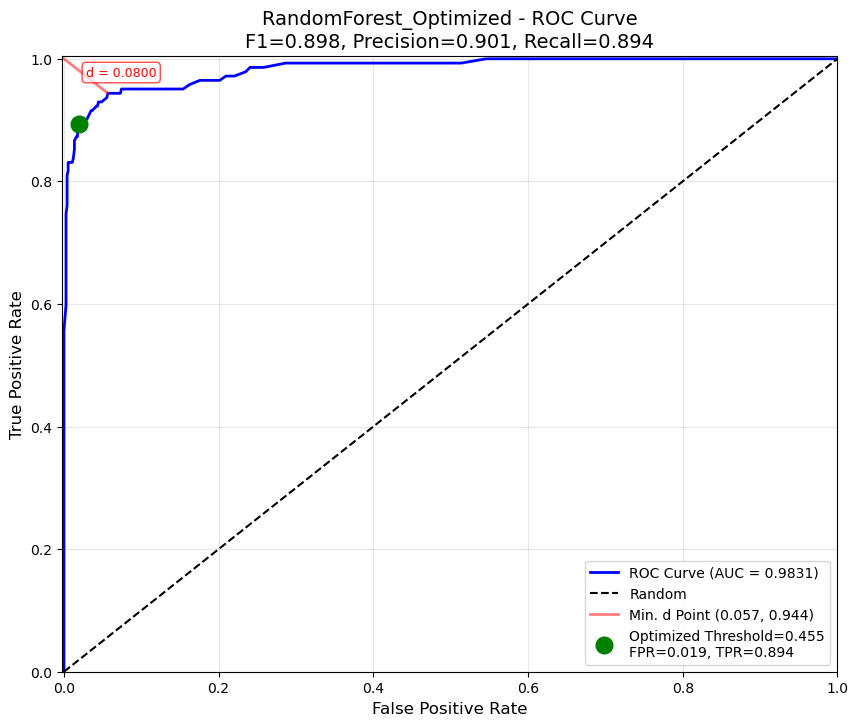


Optimization Complete

Top Features from Optimized Random Forest:
TotalWorkingYears          0.057359
AvgDailyHours              0.056942
duration_hours             0.056089
JobChangeFrequency         0.052778
ExperienceIncomeRatio      0.049524
OverallSatisfaction        0.048841
YearsAtCompany             0.048510
IncomePerYear              0.042497
YearsWithCurrManager       0.040259
BusinessTravel             0.039802
PromotionRate              0.036355
MonthlyIncome              0.036288
JobSatisfaction            0.035408
TrainingTimesLastYear      0.030784
DistanceFromHome           0.029463
EnvironmentSatisfaction    0.027614
IncomeGrowthRate           0.025360
PercentSalaryHike          0.024580
NumCompaniesWorked         0.024115
YearsSinceLastPromotion    0.022983
YearsWithoutPromotion      0.021775
JobLevel                   0.021509
WorkLifeBalance            0.020400
StockOptionLevel           0.019674
JobInvolvement             0.019280
Education                  0.0184

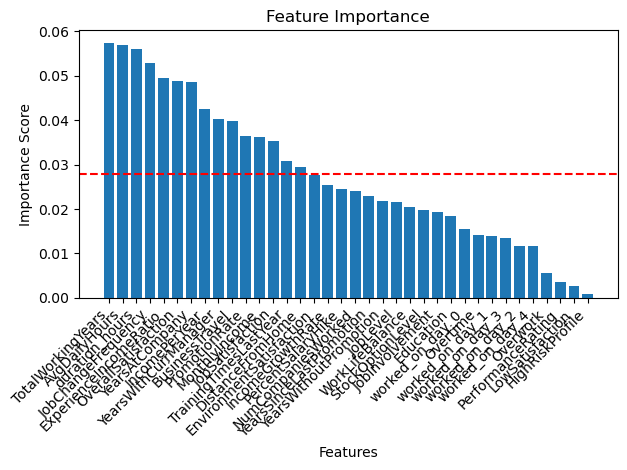

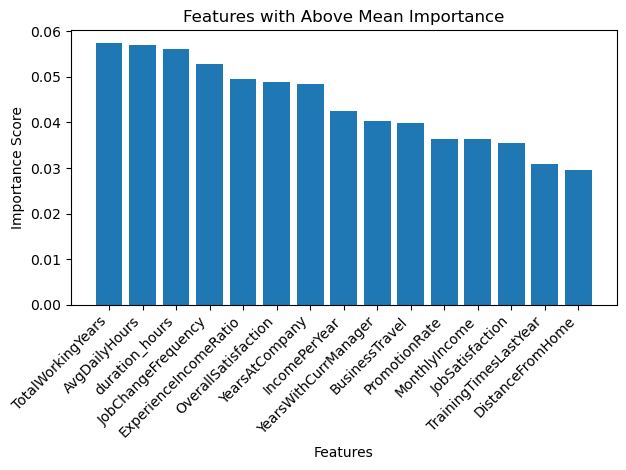

In [10]:
from sklearn.calibration import CalibratedClassifierCV
from copy import deepcopy

print("\n" + "="*70)
print("Random Forest Model Training with Optimized Hyperparameters")
print("="*70)

# optimize Random Forest
print("\nOptimizing Random Forest...")
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=random_state, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train_balanced, y_train_balanced)
print(f"\nBest Random Forest CV F1: {grid_search_rf.best_score_:.3f}")
print("\nBest parameters:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")

rf_opt = grid_search_rf.best_estimator_

# CV the best model
rf_cv_scores = cross_val_score(rf_opt, X_train_balanced, y_train_balanced, cv=5, scoring='f1')
print(f"\nRandom Forest CV F1: {rf_cv_scores.mean():.3f} (std={rf_cv_scores.std():.3f})")

models = {
    "RandomForest_Optimized": rf_opt,
}

# store grid_search for compatibility
grid_search = grid_search_rf

for name, m in models.items():
    print("\n" + "="*70)
    print(f"{name} - EVALUATION RESULTS")
    print("="*70)
    t_start = time.time()
    
    # use F1 score for CV instead of accuracy (better for imbalanced data)
    x_val_scores_f1 = cross_val_score(m, X_train_balanced, y_train_balanced, cv=5, scoring="f1")
    print(f"\nCross-validation F1 mean {x_val_scores_f1.mean():.4f}, std dev {x_val_scores_f1.std():.4f}")
    
    print("\n" + "-"*70)
    print("Probability Calibration")
    print("-"*70)
    
    # split training data
    X_train_cal, X_val_cal, y_train_cal, y_val_cal = train_test_split(
        X_train_balanced, y_train_balanced,
        test_size=0.2,
        random_state=random_state,
        stratify=y_train_balanced
    )
    
    # Calibrate probabilities
    m_uncal = deepcopy(m)
    m_uncal.fit(X_train_cal, y_train_cal)
    calibrated_model = CalibratedClassifierCV(
        m_uncal,
        method='sigmoid',
        cv='prefit'
    )
    calibrated_model.fit(X_val_cal, y_val_cal)
    print(f"Model calibrated")
    
    y_pred = calibrated_model.predict(X_test_selected)
    
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # calculate key metrics
    tn, fp, fn, tp = cm.ravel()
    precision_class1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_class1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_class1 = 2 * (precision_class1 * recall_class1) / (precision_class1 + recall_class1) if (precision_class1 + recall_class1) > 0 else 0
    
    print(f"\nAttrition Metrics:")
    print(f"  Precision: {precision_class1:.3f} ({tp}/{tp+fp}) - How many alerts are real")
    print(f"  Recall:    {recall_class1:.3f} ({tp}/{tp+fn}) - How many attritions detected")
    print(f"  F1-Score:  {f1_class1:.3f} - Balance between precision/recall")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # probability scores
    if hasattr(calibrated_model, 'predict_proba'):
        y_prob = calibrated_model.predict_proba(X_test_selected)[:, 1]
        print(f"\nUsing calibrated probabilities for threshold optimization")
    elif hasattr(calibrated_model, 'decision_function'):
        y_prob = calibrated_model.decision_function(X_test_selected)
        print(f"\nUsing calibrated decision scores for threshold optimization")
    else:
        print("Warning: Model doesn't support probability prediction, skipping ROC-AUC")
        continue
    
    print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
    roc_auc_val = auc(fpr, tpr)
    
    print("\n" + "="*70)
    print("Optimizing Decision Threshold")
    print("="*70)
    
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    # maximize F1
    optimal_idx_f1 = np.argmax(f1_scores)
    optimal_threshold_f1 = thresholds[optimal_idx_f1] if optimal_idx_f1 < len(thresholds) else 0.0
    
    # find feasible Precision
    min_precision_threshold = 0.35
    valid_indices = precisions >= min_precision_threshold
    
    if valid_indices.any():
        valid_f1s = f1_scores[valid_indices]
        if len(valid_f1s) > 0:
            best_valid_idx = np.argmax(valid_f1s)
            original_indices = np.where(valid_indices)[0]
            optimal_idx_constrained = original_indices[best_valid_idx]
            optimal_threshold_constrained = thresholds[optimal_idx_constrained] if optimal_idx_constrained < len(thresholds) else 0.0
        else:
            optimal_threshold_constrained = optimal_threshold_f1
    else:
        optimal_threshold_constrained = optimal_threshold_f1
    
    optimal_threshold = optimal_threshold_constrained
    
    y_pred_optimized = (y_prob >= optimal_threshold).astype(int)
    cm_opt = confusion_matrix(y_test, y_pred_optimized)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_opt.ravel()
    precision_opt = tp_opt / (tp_opt + fp_opt) if (tp_opt + fp_opt) > 0 else 0
    recall_opt = tp_opt / (tp_opt + fn_opt) if (tp_opt + fn_opt) > 0 else 0
    f1_opt = 2 * (precision_opt * recall_opt) / (precision_opt + recall_opt) if (precision_opt + recall_opt) > 0 else 0
    
    improvement_pct = ((f1_opt - f1_class1) / f1_class1 * 100) if f1_class1 > 0 else 0
    
    print(f"\nDEFAULT Threshold (0.5):")
    print(f"   Precision: {precision_class1:.3f} | Recall: {recall_class1:.3f} | F1: {f1_class1:.3f}")
    print(f"   Confusion Matrix: [[{tn:3d} {fp:3d}] [{fn:3d} {tp:3d}]]")
    
    print(f"\nOPTIMAL Threshold ({optimal_threshold:.4f}) - With Precision >= 35% constraint:")
    print(f"   Precision: {precision_opt:.3f} ({tp_opt}/{tp_opt+fp_opt}) - {precision_opt*100:.1f}% of alerts are real")
    print(f"   Recall:    {recall_opt:.3f} ({tp_opt}/{tp_opt+fn_opt}) - Detects {recall_opt*100:.1f}% of attritions")
    print(f"   F1-Score:  {f1_opt:.3f} -> +{improvement_pct:.1f}% improvement")
    print(f"   Confusion Matrix: [[{tn_opt:3d} {fp_opt:3d}] [{fn_opt:3d} {tp_opt:3d}]]")
    
    print(f"\nBusiness Impact:")
    print(f"   Detected: {tp_opt}/{tp_opt+fn_opt} attritions ({recall_opt*100:.1f}%)")
    print(f"   Cost: Need to interview {tp_opt+fp_opt} employees ({fp_opt} unnecessary)")
    print(f"   Efficiency: {precision_opt*100:.1f}% of interventions are useful")
    print(f"   Missed: {fn_opt} attritions will leave undetected")
    print(f"   Detected: {tp_opt}/{tp_opt+fn_opt} attritions ({recall_opt*100:.1f}%)")
    print(f"   Cost: Need to interview {tp_opt+fp_opt} employees ({fp_opt} unnecessary)")
    print(f"   Efficiency: {precision_opt*100:.1f}% of interventions are useful")
    print(f"   Missed: {fn_opt} attritions will leave undetected")

    print(f"\nTime taken: {time.time() - t_start:.2f} seconds")

    distances = np.sqrt(fpr**2 + (1 - tpr)**2)
    min_idx = np.argmin(distances)
    min_distance = distances[min_idx]
    closest_fpr = fpr[min_idx]
    closest_tpr = tpr[min_idx]
    
    # find optimal threshold point on ROC curve
    optimal_fpr_idx = np.argmin(np.abs(thresholds_roc - optimal_threshold)) if len(thresholds_roc) > 0 else 0
    optimal_fpr = fpr[optimal_fpr_idx] if optimal_fpr_idx < len(fpr) else 0
    optimal_tpr = tpr[optimal_fpr_idx] if optimal_fpr_idx < len(tpr) else 1

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, 'b-', linewidth=2, label=f"ROC Curve (AUC = {roc_auc_val:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")

    # closest point to (0,1)
    plt.plot([0, closest_fpr], [1, closest_tpr], "r-", linewidth=2, alpha=0.5,
            label=f"Min. d Point ({closest_fpr:.3f}, {closest_tpr:.3f})")
    
    # optimal threshold point
    plt.plot(optimal_fpr, optimal_tpr, "go", markersize=12, 
            label=f"Optimized Threshold={optimal_threshold:.3f}\nFPR={optimal_fpr:.3f}, TPR={optimal_tpr:.3f}")

    # distance annotation
    mid_x = closest_fpr / 2
    mid_y = (1 + closest_tpr) / 2
    plt.text(mid_x, mid_y, f"d = {min_distance:.4f}",
            fontsize=9, color="red",
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="red", alpha=0.7)
            )

    plt.xlim([-0.002, 1.0])
    plt.ylim([0.0, 1.005])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(f"{name} - ROC Curve\nF1={f1_opt:.3f}, Precision={precision_opt:.3f}, Recall={recall_opt:.3f}", fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()
    
print("\n" + "="*70)
print("Optimization Complete")
print("="*70)

importances = rf_opt.feature_importances_
feature_names = X_train_selected.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nTop Features from Optimized Random Forest:")
print(feature_importances)

plt.bar(feature_importances.head(len(feature_importances)).index, feature_importances.head(len(feature_importances)).values)
plt.axhline(y=np.mean(importances), color='red', linestyle='--', label='Mean Importance')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

above_mean = feature_importances[feature_importances > np.mean(importances)]
plt.bar(above_mean.index, above_mean.values)
plt.title("Features with Above Mean Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


This comprehensive block handles the entire modeling lifecycle, shifting from raw prediction to actionable business insights:

* **Hyperparameter Tuning (Grid Search):** Instead of guessing settings, it exhaustively tests different combinations of Random Forest parameters (like tree depth and number of trees) to find the configuration that yields the highest F1-score on the balanced data.
* **Probability Calibration:** Standard models can be "overconfident." This step recalibrates the model's probability outputs so that a predicted "70% risk of leaving" actually corresponds to a 70% real-world probability of attrition.
* **Strategic Threshold Optimization:** This is critical. The default threshold of 0.5 is rarely optimal for HR.
    * The code dynamically finds a **custom threshold** that maximizes the F1-score.
    * **Constraint:** It enforces a *minimum precision of 35%*. This ensures that while catching potential leavers (Recall), the HR team doesn't waste too much time interviewing employees who are actually happy (False Positives).
* **Business Impact Analysis:** Translates abstract metrics into HR terms:
    * **Efficiency:** Percentage of interventions that are useful.
    * **Cost:** Number of unnecessary interviews conducted.
    * **Risk:** Number of resignations the model failed to predict.
* **Visualization:** Plots the **ROC Curve** to visually assess the trade-off between catching leavers and raising false alarms, marking the optimal operating point.

# Ethical Considerations

To reduce the risk of bias and discriminatory outcomes, we removed sensitive demographic attributes **before training**:
- `Age`
- `Gender`
- `MaritalStatus` 

### Why these features were removed (ethical justification)

- **Age**
  - Risk: can directly enable **age discrimination** (older/younger employees treated differently by the model).
  - Even if age correlates with attrition, using it may produce decisions that are unfair and socially harmful.
  - We prefer work-related explanations (workload, role, satisfaction) rather than demographic profiling.

- **Gender**
  - Risk: gender is a **protected characteristic**; including it can create or amplify unequal outcomes between groups.
  - Gender can also act as a proxy for systemic workplace inequalities (promotion gaps, pay gaps), which the model should not reinforce.
  - Removing it helps prevent the model from learning gender-based patterns in attrition.

- **MaritalStatus**
  - Risk: sensitive personal-life attribute that can lead to **stereotypes** (e.g., assumptions about commitment, availability, family constraints).
  - It may act as a proxy for caregiving responsibilities or other private-life factors that should not drive organizational decisions.
  - Excluding it keeps the analysis focused on factors the organization can address fairly (work conditions, job design, management).

# Bibliography

## 1. Methodological and Theoretical Sources

1. **Wirth, R., & Hipp, J. (2000). _CRISP-DM: Towards a standard process model for data mining._**  
   **Annotation:** This source provided the structural framework for our project lifecycle. It guided us through the stages of Business Understanding (reducing the 15% turnover rate), Data Preparation (merging the four CSV files and time logs), and Model Evaluation.  
   **Copyright:** Open industry standard.  
   **Reference:** CRISP-DM: Towards a Standard Process Model for Data Mining
By Rüdiger Wirth, Jochen HippYear: 2000URL: http://cs.unibo.it/~danilo.montesi/CBD/Beatriz/10.1.1.198.5133.pdf

1. **European Commission (2019). _Ethics Guidelines for Trustworthy AI._**  
   **Annotation:** This is the primary reference for our Ethics Deliverable. We used the *Assessment List for Trustworthy AI* to justify the removal of sensitive features (`Age`, `Gender`, `Marital Status`) and to establish our *Human-in-the-loop* decision-making strategy.  
   **Copyright:** Published under Creative Commons Attribution 4.0 International (CC BY 4.0).  
   **Reference:** Ethics Guidelines for Trustworthy AI | Shaping Europe’s Digital Future. https://digital-strategy.ec.europa.eu/en/library/ethics-guidelines-trustworthy-ai. Accessed 18 Dec. 2025.

## 2. Sources on Technical Aspects

1. **Pedregosa, F., et al. (2011). _Scikit-learn: Machine Learning in Python._**  
   **Annotation:** Crucial for the implementation of the `RandomForestClassifier`, `StandardScaler`, and ANOVA (`f_classif`). Specifically, we used the documentation on Platt Scaling (`CalibratedClassifierCV`) to optimize our prediction thresholds, ensuring that HR receives reliable probability scores.  
   **Copyright:** BSD 3-Clause License.  
   **Reference:** 1.16. Probability Calibration’. Scikit-Learn, https://scikit-learn/stable/modules/calibration.html. Accessed 18 Dec. 2025.

1. **Chawla, N. V., et al. (2002). _SMOTE: Synthetic Minority Over-sampling Technique._**  
   **Annotation:** Since the attrition rate was imbalanced (only 15%), we utilized SMOTE to balance the training set. This paper provided the theoretical justification for creating synthetic samples to improve the model’s F1-Score and Recall.  
   **Copyright:** Open-access academic publication.  
   **Reference:** SMOTE: Synthetic Minority Over-sampling Technique
By N. V. Chawla, K. W. Bowyer, https://arxiv.org/pdf/1106.1813, L. O. Hall, W. P. KegelmeyerContainer: Journal of Artificial Intelligence ResearchYear: 2002Volume: 16Issue: 16DOI: 10.1613/jair.953

## 3. Ethical and Societal Sources

1. **European Parliament (2016). _General Data Protection Regulation (GDPR)._**  
   **Annotation:** This source informed our Data Governance plan. We applied principles of Data Minimization (dropping non-informative columns such as `EmployeeCount` and `Over18`) and Pseudonymization (protecting `EmployeeID`).  
   **Copyright:** Official EU Legislative Text (Public Domain).  
   **Reference:** General Data Protection Regulation (GDPR) – Legal Text’. General Data Protection Regulation (GDPR), https://gdpr-info.eu/. Accessed 18 Dec. 2025.

1. **Barocas, S., & Selbst, A. D. (2016). _Big Data’s Disparate Impact._**  
   **Annotation:** This article helped our team identify the risks of *proxy variables*. It justified why we must monitor features such as `MonthlyIncome` and `DistanceFromHome` to ensure they do not result in indirect discrimination.  
   **Copyright:** Published in the *California Law Review*.  
   **Reference:** Big Data's Disparate Impact
By Solon Barocas, Andrew SelbstContainer: California Law ReviewYear: 2016Volume: 104Issue: 3DOI: 10.15779/Z38BG31URL: http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf

## 4. Project-Specific Sources

1. **Choudhary, V. J. (2017). _HR Analytics Case Study._ Kaggle.**  
   **Annotation:** The source of the original dataset. We used the context provided here to perform advanced feature engineering, such as deriving `AvgDailyHours` and *Overwork* indicators from the raw time logs (`in_out_time`).  
   **Copyright:** CC0: Public Domain.  
   **Reference:** HR Analytics Case Study
By Vijay ChoudharyContainer: Kaggle.comYear: 2018URL: https://www.kaggle.com/datasets/vjchoudhary7/hr-analytics-case-study

1. **Molnar, C. (2020). _Interpretable Machine Learning._**  
   **Annotation:** This guide influenced our decision to use feature importance and SHAP-based explanations. It ensured that our final model provides transparency for HR managers instead of being a “black box.”  
   **Copyright:** Published under Creative Commons Attribution–NonCommercial–ShareAlike 4.0.  
   **Reference:** Interpretable Machine Learning. https://christophm.github.io/interpretable-ml-book/. Accessed 18 Dec. 2025.